In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train_and_test2.csv
/kaggle/input/c/titanic/train.csv
/kaggle/input/c/titanic/test.csv
/kaggle/input/c/titanic/gender_submission.csv


**Importing the data**

In [2]:
import numpy as np
import pandas as pd


#reading the files and creating a dataframe with both train and test
ttest = pd.read_csv("/kaggle/input/c/titanic/test.csv")
ttrain = pd.read_csv("/kaggle/input/c/titanic/train.csv")
gendersub = pd.read_csv("/kaggle/input/c/titanic/gender_submission.csv")
tfull = pd.concat([ttrain,ttest]).reset_index(drop = True)

 # Initial look:

In [3]:
print(ttrain.head())
print(ttrain.info())
print(ttrain.columns)
print(ttrain.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

probably useless util func but I'm scared of deleting functions

In [4]:
def n_unique(df, col):
    return len(df[col].unique())

In [5]:
#Define what columns are numerical. The rest is assigned as categorical.
#The numerical columns that have few distinct values get a categorical version.
#The reason for that is for the graphs. You'll see later
numerical = {'Age','Fare','SibSp', 'Parch'}
categorical = set(ttrain.columns).difference(numerical)
cat_and_num = set()
for col in numerical:
    if(n_unique(ttrain,col) < 10):
        cat_and_num.add(col)

#splitting the data to apply the describe function
ttrain_num = ttrain[numerical]
ttrain_cat = ttrain[categorical]

In [6]:
print(ttrain_num.describe())
print('\n')
print(ttrain_cat.astype('category').describe())

             Fare       Parch         Age       SibSp
count  891.000000  891.000000  714.000000  891.000000
mean    32.204208    0.381594   29.699118    0.523008
std     49.693429    0.806057   14.526497    1.102743
min      0.000000    0.000000    0.420000    0.000000
25%      7.910400    0.000000   20.125000    0.000000
50%     14.454200    0.000000   28.000000    0.000000
75%     31.000000    0.000000   38.000000    1.000000
max    512.329200    6.000000   80.000000    8.000000


                       Name        Cabin Ticket  Survived   Sex  PassengerId  \
count                   891          204    891       891   891          891   
unique                  891          147    681         2     2          891   
top     Abbing, Mr. Anthony  C23 C25 C27   1601         0  male            1   
freq                      1            4      7       549   577            1   

        Pclass Embarked  
count      891      889  
unique       3        3  
top          3        S  
freq   

# Now we will try to extract info from the weird columns: Name, Ticket, Cabin.
Starting with Name:

In [7]:
#printing the names to figure out if there is anything to do with them
#np.sort(ttrain['Name'].unique())

Looks like they are on the form '{name}, {Title} {last_name...} ({real_name}) "{nick_name}"
Lets separate them cause we might as well. #The column names are all camelcase so ill just keep it like that.

In [8]:
# Hwere we define some functions that we will apply to the Name column to get specific parts. Apo = Apostrophe, Par = Parenthesis

def parsep(x):
    if '(' in x and ')' in x:
        return x.split('(')[1].split(')')[0]
    else:
        return None
    
def aposep(x):
    if '"' in x:
        return x.split('"')[1].split('"')[0]
    else:
        return None

def gensep(string, suba, subb):
    for a in suba:
        for b in subb:
            if a in string and b in string:
                return string.split(a)[1].split(b)[0]
    for a in suba:
        if a in string:
            return string.split(a)[1]
    
    for b in subb:
        return string.split(b)[0]
            


In [9]:
#just testing the function
#gensep('-hello world-','-','-')


In [10]:

#getting last name, first name, title, parenthesis name and apostrophe name. 
ttrain['LastName'] = ttrain['Name'].apply(lambda x: x.split(', ')[0])
ttrain['FirstName'] = ttrain['Name'].apply(lambda x: gensep(x, ['. '], ['(','"']))
ttrain['Title'] = ttrain['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])
#Name Parenthesis
ttrain['ParName'] = ttrain['Name'].apply(parsep)
#Name Apostrophe
ttrain['ApoName'] = ttrain['Name'].apply(aposep)

#doing the same thing for the test part. I know, it's silly, should have done to them combined, but when I first wrote
#this part I wasn't thinking about the test set. Neginner mistake I suppose. Or just silliness.
ttest['LastName'] = ttest['Name'].apply(lambda x: x.split(', ')[0])
ttest['FirstName'] = ttest['Name'].apply(lambda x: gensep(x, ['. '], ['(','"']))
ttest['Title'] = ttest['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])
#Name Parenthesis
ttest['ParName'] = ttest['Name'].apply(parsep)
#Name Apostrophe
ttest['ApoName'] = ttest['Name'].apply(aposep)

#checking if it worked
ttrain[['Name','LastName','Title','ParName','ApoName','FirstName']]
#ttrain['Title'].unique()

,Name,LastName,Title,ParName,ApoName,FirstName
0,"Braund, Mr. Owen Harris",Braund,Mr,None,None,Owen Harris
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Mrs,Florence Briggs Thayer,None,John Bradley
2,"Heikkinen, Miss. Laina",Heikkinen,Miss,None,None,Laina
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Mrs,Lily May Peel,None,Jacques Heath
4,"Allen, Mr. William Henry",Allen,Mr,None,None,William Henry
...,...,...,...,...,...,...
886,"Montvila, Rev. Juozas",Montvila,Rev,None,None,Juozas
887,"Graham, Miss. Margaret Edith",Graham,Miss,None,None,Margaret Edith
888,"Johnston, Miss. Catherine Helen ""Carrie""",Johnston,Miss,None,Carrie,Catherine Helen
889,"Behr, Mr. Karl Howell",Behr,Mr,None,None,Karl Howell


In [11]:
#unique titles
print(ttrain['Title'].unique())


#creating a SocialH feature. It just tells you if you have a special title.
def hierarchy(x):
    if x in ['Mr','Mrs','Ms', 'Miss']:
        return 'low'
    else:
        return 'high'
    
#social hierarchy. 
ttrain['SocialH'] = ttrain['Title'].apply(hierarchy)
ttest['SocialH'] = ttest['Title'].apply(hierarchy)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


# Tickets
Okay. Now the names are split. Should come back to them afterwards. But first, lets take a look at cabin and ticket.

In [12]:
# As with names, just take a first look at it. The dataset is ont that big so might as well print them all
#np.sort(ttrain.Ticket.values)

There is a letter part and a number part. Some tickets are the same, presumably because they were bought as a group. We can make a feature out of that. Maybe later figure out the missing cabins? For now, I'm just separating the letter and number parts, though there might be more info contained in the tickets.

In [13]:
# Separating into LP = Letter Part and NP = Number Part
ttrain['TicketLP'] = ttrain['Ticket'].apply(lambda x: ''.join(x.split()[:-1]))
ttrain['TicketNP'] = ttrain['Ticket'].apply(lambda x: x.split()[-1])

ttest['TicketLP'] = ttest['Ticket'].apply(lambda x: ''.join(x.split()[:-1]))
ttest['TicketNP'] = ttest['Ticket'].apply(lambda x: x.split()[-1])

# Checking if it's all correct
ttrain[['Ticket','TicketLP','TicketNP']]

,Ticket,TicketLP,TicketNP
0,A/5 21171,A/5,21171
1,PC 17599,PC,17599
2,STON/O2. 3101282,STON/O2.,3101282
3,113803,,113803
4,373450,,373450
...,...,...,...
886,211536,,211536
887,112053,,112053
888,W./C. 6607,W./C.,6607
889,111369,,111369


I want to look into them further later.

In [14]:
#np.sort(ttrain['TicketNP'].values.astype(int))

Finally the cabin:

# Cabin

In [15]:
#ttrain['Cabin'].unique()

We can get the letters. Might have to do with where you were on the ship. Also number of cabins. 

In [16]:
# function for extracting the cabin letters
def cletters(x):
    if not str(x) == 'nan':
        cletters = ''
        for p in x.split():
            cletters += p[0]
        return cletters


In [17]:
#first number of cabins:
ttrain['NCabins'] = ttrain['Cabin'].apply(lambda x: len(x.split()) if not str(x) == 'nan' else 0)
#According to the function on the cell above, we fill in the cabin letters
ttrain['CabinLetters'] = ttrain['Cabin'].apply(cletters)

#first number of cabins:
ttest['NCabins'] = ttest['Cabin'].apply(lambda x: len(x.split()) if not str(x) == 'nan' else 0)
#According to the function on the cell above, we fill in the cabin letters
ttest['CabinLetters'] = ttest['Cabin'].apply(cletters)

# Checking that it works as usual
ttrain[['Cabin','NCabins','CabinLetters']]

,Cabin,NCabins,CabinLetters
0,NaN,0,None
1,C85,1,C
2,NaN,0,None
3,C123,1,C
4,NaN,0,None
...,...,...,...
886,NaN,0,None
887,B42,1,B
888,NaN,0,None
889,C148,1,C


In [18]:
#lets reduce parname and aponame to just a boolean: having or not having one. Also for others which apply.
has_blah_blah = {'ParName', 'ApoName', 'Cabin'}
for has in has_blah_blah:
    ttrain[f'Has{has}'] = ~ttrain[f'{has}'].isna()
    ttest[f'Has{has}'] = ~ttest[f'{has}'].isna()
    



Finding the families. I suspect families died or lived together.

In [19]:
#returns the number of dead passengers with the same ticket, but with a different passengerid. needs improvement
def n_dead_family(id, ticket):
    n = ttrain[(ttrain['Ticket'] == ticket) & (ttrain['PassengerId'] != id)]['Survived'].apply(
        lambda x: True if x == 0 else False).sum()
    return n

In [20]:
#applying the function
ttrain['DeadFamilyMembers'] = ttrain.apply(
    lambda row: n_dead_family(row['PassengerId'],row['Ticket']), axis = 1)

ttest['DeadFamilyMembers'] = ttest.apply(
    lambda row: n_dead_family(row['PassengerId'],row['Ticket']), axis = 1)

# checking
ttrain[['DeadFamilyMembers', 'Ticket','Survived']].sort_values('Ticket')
# I wonder if women who lost their husbands had better chances of surviving?

,DeadFamilyMembers,Ticket,Survived
504,0,110152,1
257,0,110152,1
759,0,110152,1
262,0,110413,0
558,1,110413,1
...,...,...,...
235,0,W./C. 6609,0
92,0,W.E.P. 5734,0
219,0,W/C 14208,0
540,1,WE/P 5735,1


In [21]:
# this is just for testing, please ignore
"""
ttrain[ttrain.duplicated('LastName')]['LastName'].sort_values()
ttrain[ttrain['LastName'] == 'Abbott']
gr_by_ticket = ttrain.groupby('Ticket').count()
gr_by_ticket[gr_by_ticket['PassengerId'] > 1]['PassengerId'].sort_values()
"""

"\nttrain[ttrain.duplicated('LastName')]['LastName'].sort_values()\nttrain[ttrain['LastName'] == 'Abbott']\ngr_by_ticket = ttrain.groupby('Ticket').count()\ngr_by_ticket[gr_by_ticket['PassengerId'] > 1]['PassengerId'].sort_values()\n"

In [22]:
#ttrain['LastName'].sort_values()

Ok, we will come back to that later. I think that should be enough for a first glance. Lets look at the missing values and then do some visualizations.

# Graphing!

In [23]:
# maybe there is a way of just rerunning this cell, but I dont know how 
# so i just copied and pasted it back here. Could've written a func
numerical = {'Age','Fare','SibSp', 'Parch'}
categorical = set(ttrain.columns).difference(numerical)
cat_and_num = set()
for col in numerical:
    if(n_unique(ttrain,col) < 10):
        cat_and_num.add(col)


ttrain_num = ttrain[numerical]
ttrain_cat = ttrain[categorical]

Looking at the distributions of the categorical variables. You can rerun this cell after running the notebook to get extra graphs.

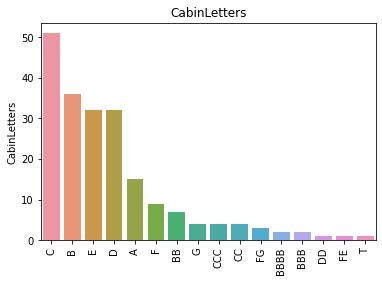

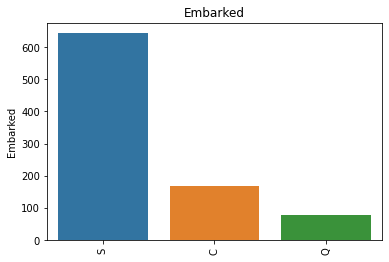

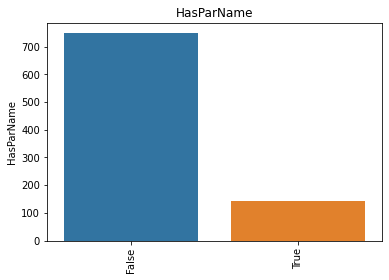

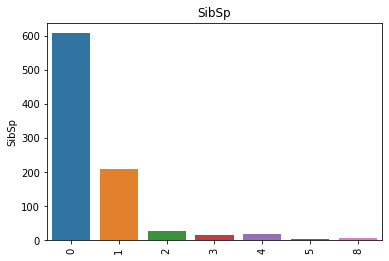

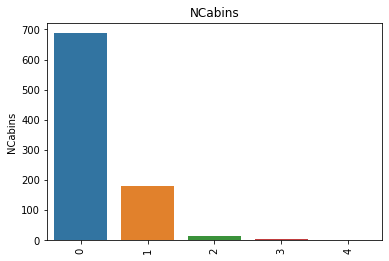

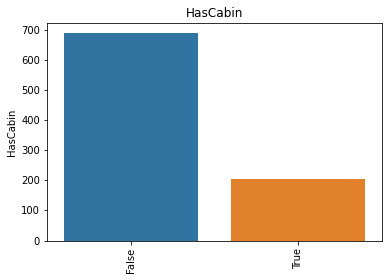

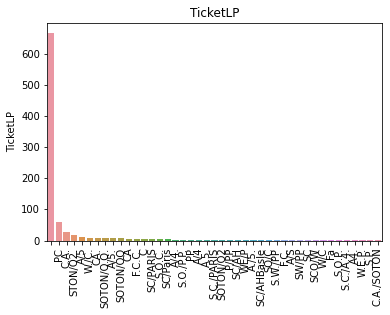

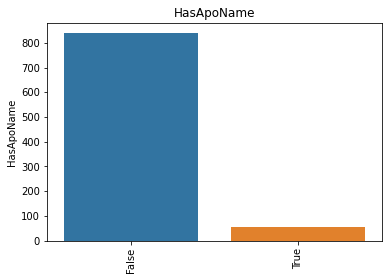

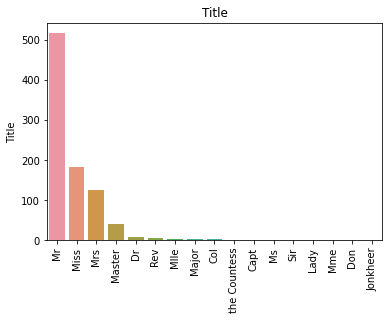

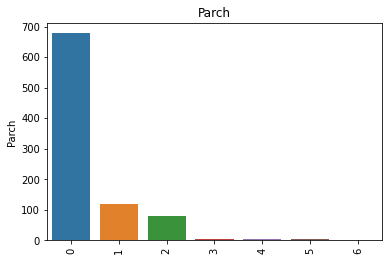

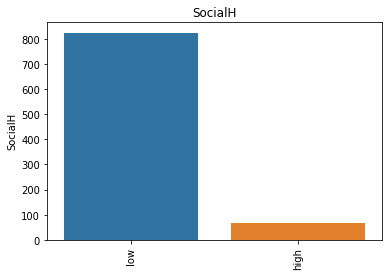

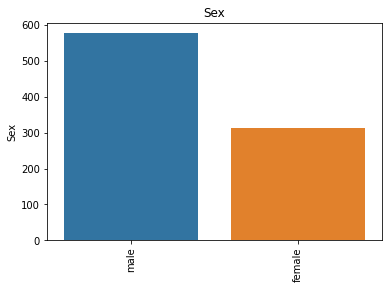

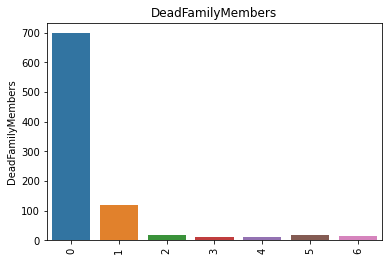

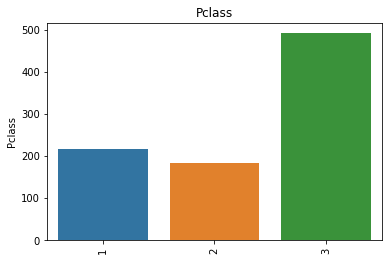

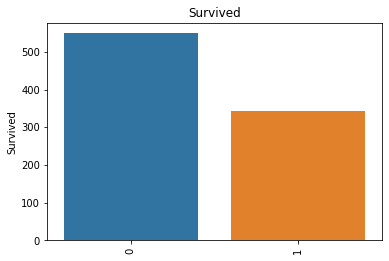

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# dummies are the columns you don't necessarily want to graph. Remember it will appear later
dummies = {'ApoName', 'ParName', 'Cabin', 'FirstName', 'LastName', 'Name', 'Ticket', 'TicketNP', 'PassengerId'}

# Making plots of the categorical variables
for category in categorical.difference(dummies).union(cat_and_num):
    plt.xticks(rotation = 90)
    sns.barplot(x = ttrain[category].value_counts().index,
                y = ttrain[category].value_counts())
    plt.title(category)
    plt.show()

Now we make the same graphs but with hues:

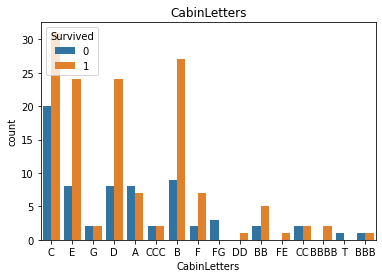

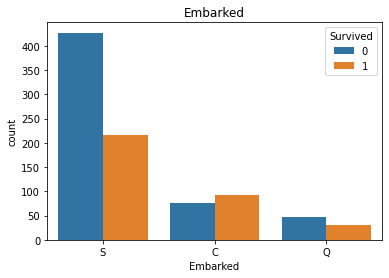

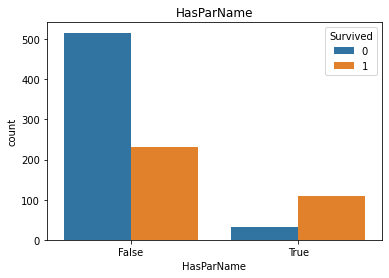

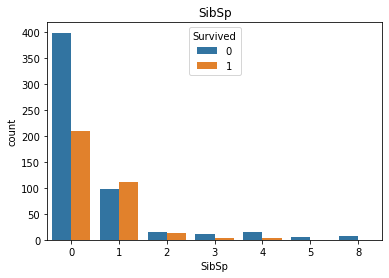

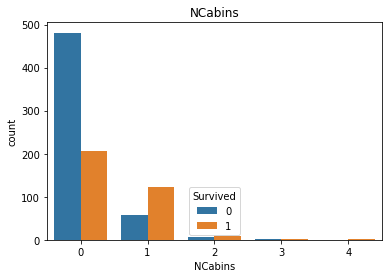

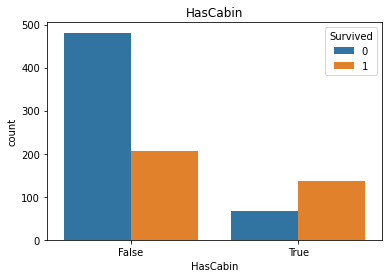

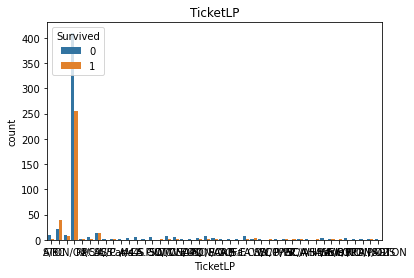

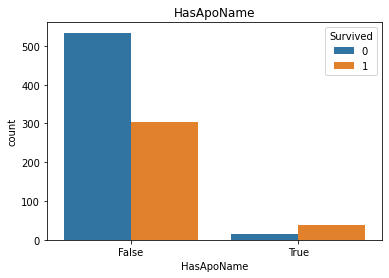

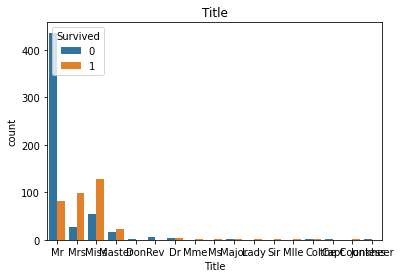

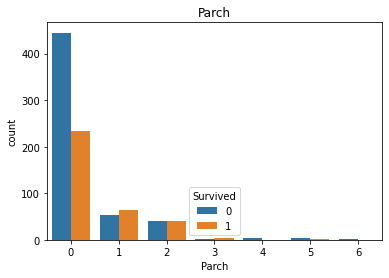

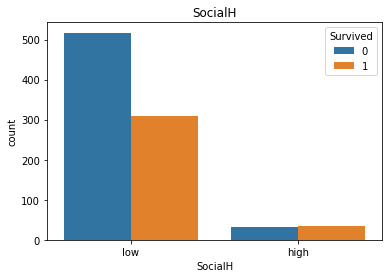

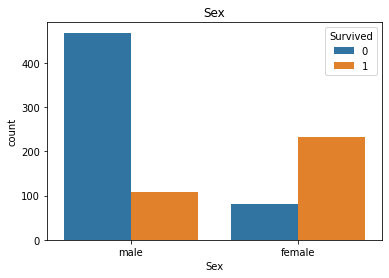

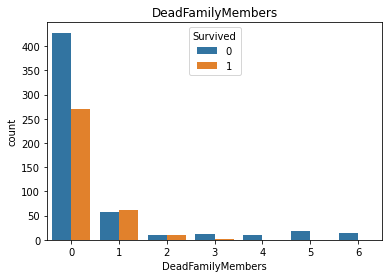

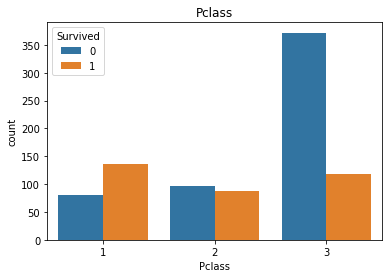

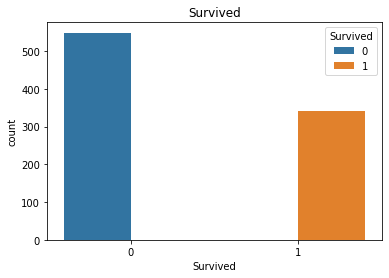

In [25]:
for category in categorical.difference(dummies).union(cat_and_num):
    _ = sns.countplot(data = ttrain, x = category, hue = 'Survived')
    _ = _.set(title = category)
    plt.show()
    

Now we will plot histograms for the numerical variables. The number of bins is the square root of the sample size.

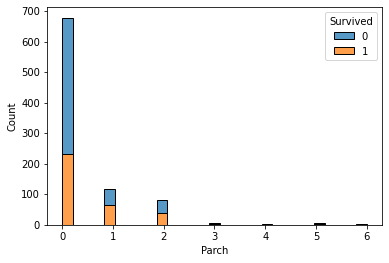

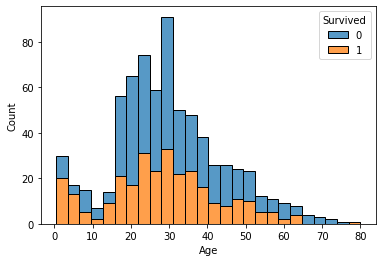

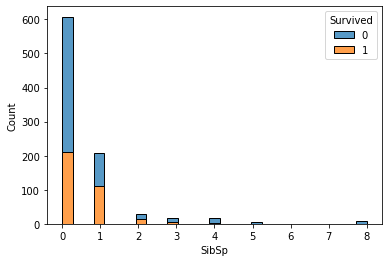

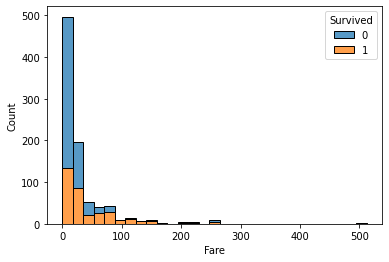

In [26]:
for num in numerical.union(cat_and_num): 
    n_bins = np.sqrt(ttrain[num].isna().apply(lambda x: not x).sum())
    sns.histplot(x = ttrain[num], hue = ttrain['Survived'], bins = int(n_bins), multiple = 'stack')
    plt.show()

# Cleaning the data
# Missing values:

In [27]:
ttrain_missing = ttrain #saving current state of ttrain so we can explore the missing values

AxesSubplot(0.125,0.125;0.698618x0.755)
PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
LastName               0
FirstName              0
Title                  0
ParName              748
ApoName              838
SocialH                0
TicketLP               0
TicketNP               0
NCabins                0
CabinLetters         687
HasCabin               0
HasApoName             0
HasParName             0
DeadFamilyMembers      0
dtype: int64


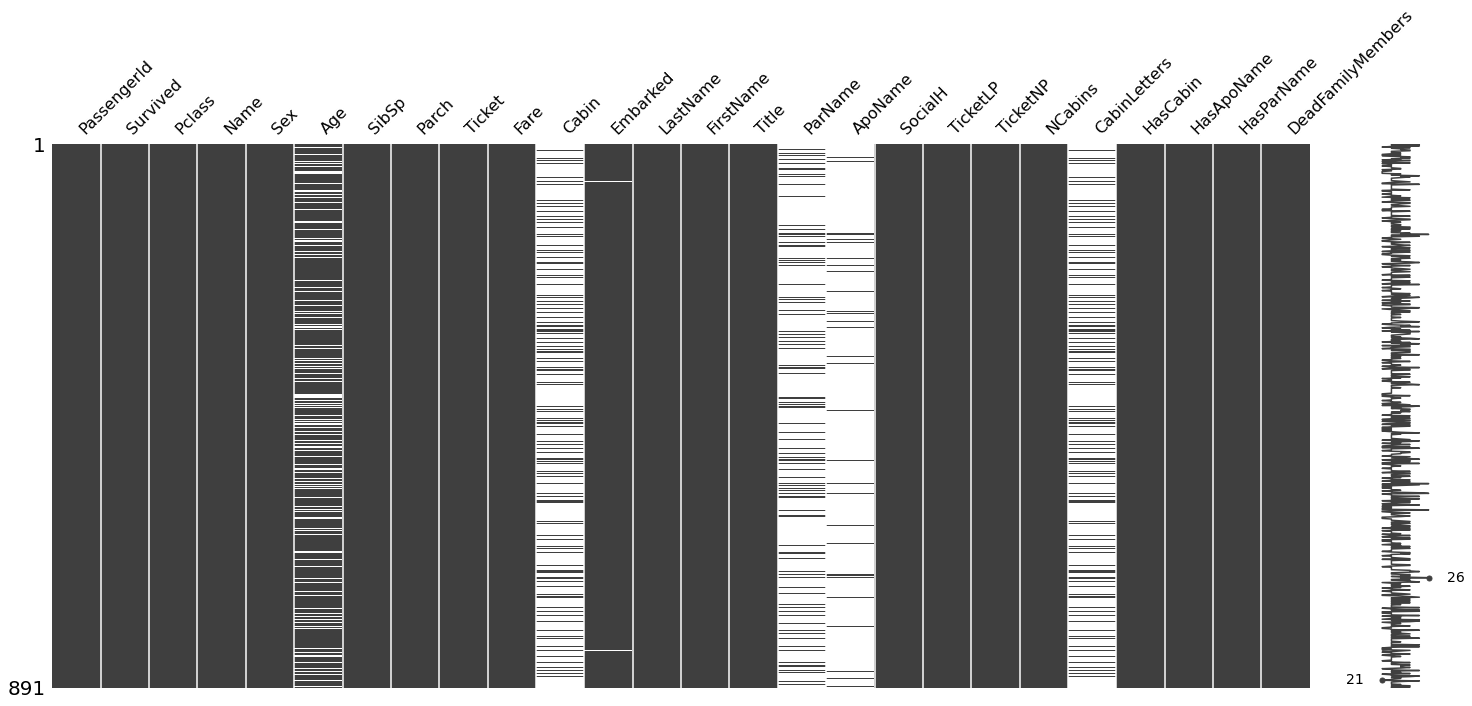

In [28]:
import missingno as msno

# looking at what values are missing for both the train and test sets:
print(msno.matrix(ttrain))
print(ttrain.isna().sum())

AxesSubplot(0.125,0.125;0.698618x0.755)
PassengerId            0
Pclass                 0
Name                   0
Sex                    0
Age                   86
SibSp                  0
Parch                  0
Ticket                 0
Fare                   1
Cabin                327
Embarked               0
LastName               0
FirstName              0
Title                  0
ParName              340
ApoName              396
SocialH                0
TicketLP               0
TicketNP               0
NCabins                0
CabinLetters         327
HasCabin               0
HasApoName             0
HasParName             0
DeadFamilyMembers      0
dtype: int64


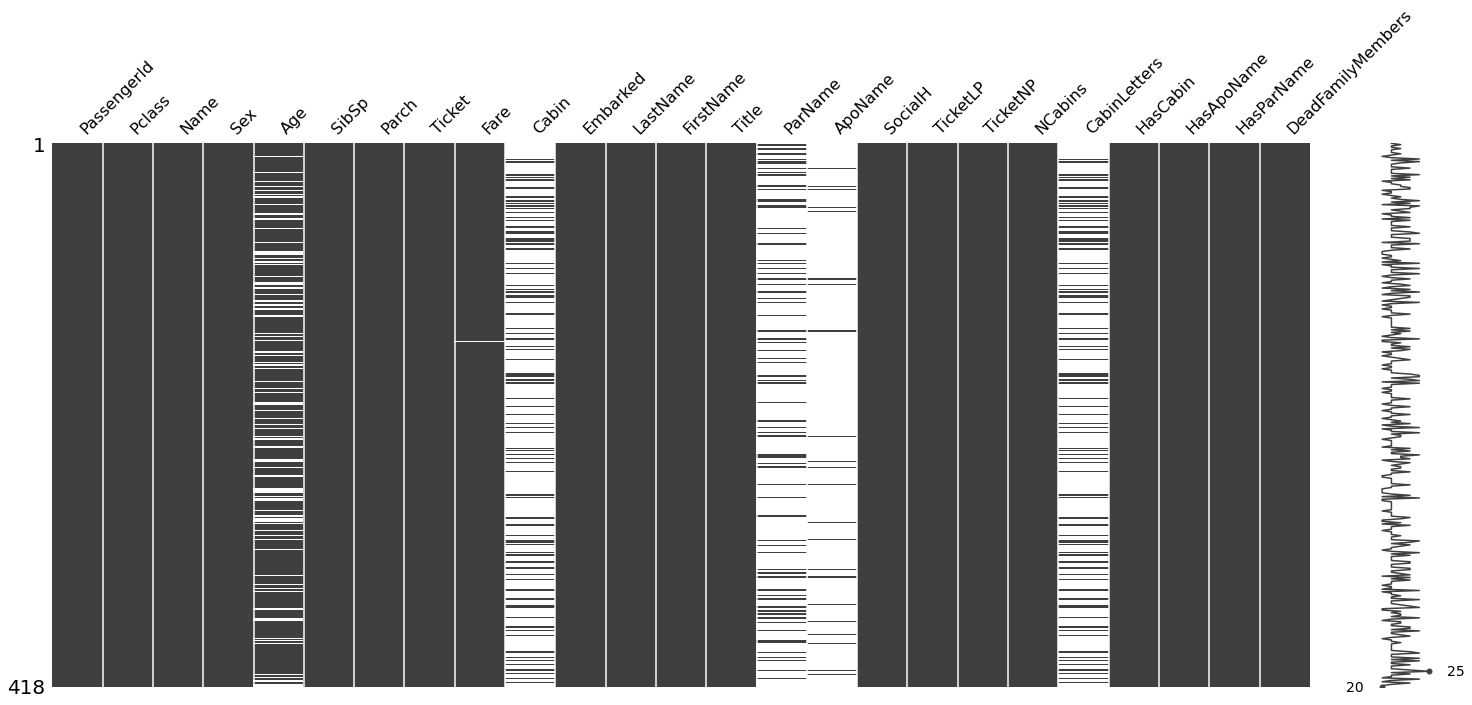

In [29]:

print(msno.matrix(ttest))
print(ttest.isna().sum())

Before filling in, lets look into possible patterns in the missing values:

<AxesSubplot:>

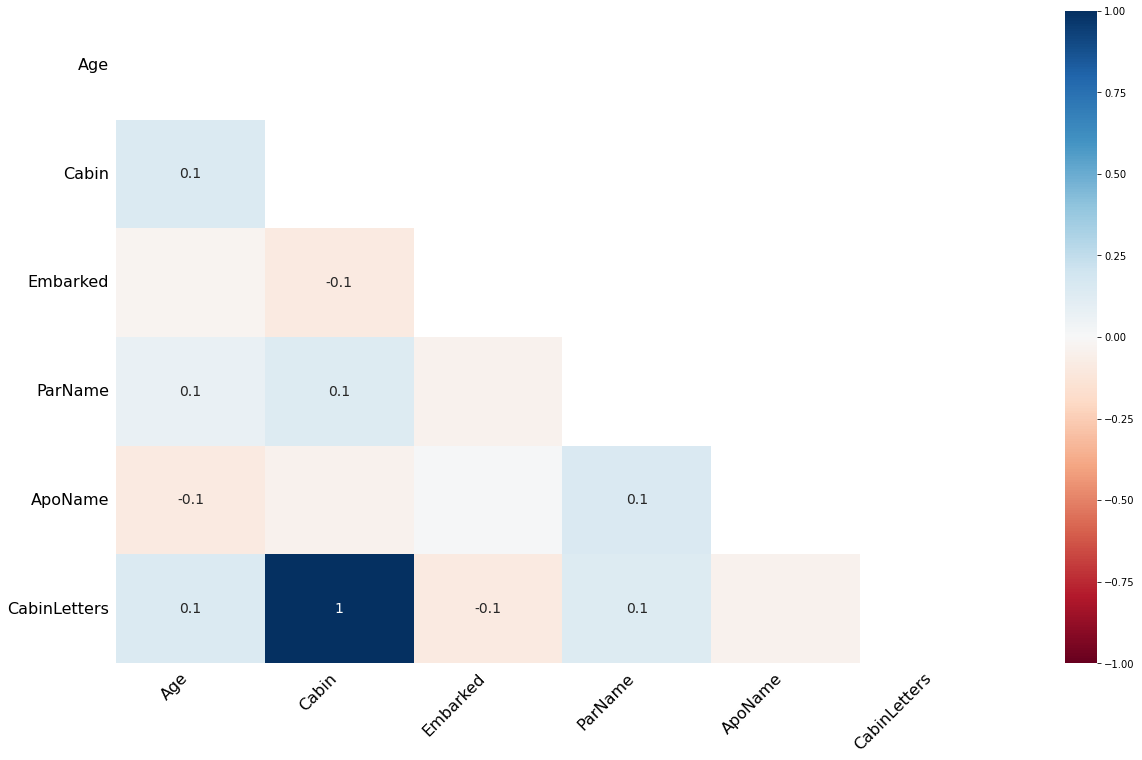

In [30]:
msno.heatmap(ttrain)

Age or cabin missing seem to be unrelated. Want to look further into the missing values, but for now
I'll just fill them with simple methods so I can move into the modelling part.

In [31]:
#we will assume whoever doesn't show a cabin, has no cabin. Other categories the 
#same rule applies:
fill_with_nos = {'Cabin', 'ParName', 'ApoName', 'CabinLetters', 'Embarked'}
for no in fill_with_nos:
    ttrain[no] = ttrain[no].fillna(f'No {no}')
    ttest[no] = ttest[no].fillna(f'No {no}')    

#for now fill age with median cause I dont know how to make a better guess.
#we should also probably save that the age was missing in some column tho.
fill_with_median = {'Age','Fare'}
for col in fill_with_median:
    ttrain[f'{col}WasMissing'] = ttrain[col].isna()
    ttrain[col] = ttrain[col].fillna(ttrain[col].median())
    
    ttest[f'{col}WasMissing'] = ttrain[col].isna()
    ttest[col] = ttest[col].fillna(ttest[col].median())
    



In [32]:
#msno.matrix(ttrain)

Nice. Now there are no missing values. Even though our filling was a bit suspicious.... We can do some modelling I guess. Maybe we get something that is OK with what we have done so far. 

Notes: 
* Missing values:
 - investigate any patterns in missing ages and cabins
 - investigate if the missing embarkments and cabins can be figured out from the ticket
 - learn more ways to deal with missing values
* Parameter Creation:
 - Investigate grouping of numerical variables.
 - Try to figure out the families. Maybe if one  member survived, then the others did too?
 - Check if data makes sense. Ages, families, tickets, classes of different family members should be connected. I would imagine high status title should also be related to the Pclass. 
 - wife/husbanddead, childrendead, parentsdead.
 

In [33]:
# this is just kind of cute values are proportion survived.
pivot = ttrain.pivot_table(index='Sex', columns='Pclass', values='Survived')
pivot

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


# Modelling!

In [34]:
# This is a function that I wrote to turn the categorical variables into numbers. 
# I suspect it is only appropriate for unordered categories.
# Ex: Embark takes values S, Q or C. This function replaces them by 0, 1, 2
def unorderedcat_to_num(*series):
    output = []
    dict_ = {}
    for serie in series:
        categories = np.sort(serie.unique())
        for cat in categories:
            if cat not in dict_.keys():
                if(dict_ == {}):
                    dict_[cat] = 0
                else:
                    dict_[cat] = max(dict_.values()) + 1
        
        #I made a terrible beginner mistake of not combining the train and test data. 
        #print(dict_)
        output.append(serie.replace(dict_))

    return output

In [35]:

#checking if the columns are the same on both the test and train data
set(ttrain.columns).difference(
set(ttest.columns))

{'Survived'}

In [36]:
#just printing all columns to help me with the next part
ttrain.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'LastName', 'FirstName',
       'Title', 'ParName', 'ApoName', 'SocialH', 'TicketLP', 'TicketNP',
       'NCabins', 'CabinLetters', 'HasCabin', 'HasApoName', 'HasParName',
       'DeadFamilyMembers', 'FareWasMissing', 'AgeWasMissing'],
      dtype='object')

Applying the ML algorithms

In [37]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE, accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#setting up a list of predictions done by different models: y

In [38]:
y_pred = {}
YPRED = {}

#preprocessing transformers: (I wrote this code before learning about pipelines)
hot = OneHotEncoder(drop = 'first')
hot.fit(ttrain)
hot.transform(ttrain)
hot.fit(ttest)
hot.transform(ttest)


#turning categories into numbers (running on the above function):
unordered_cats = {'Sex','Embarked','Title','SocialH','CabinLetters','TicketLP','Cabin'}

for cat in unordered_cats:
    ttrain[cat], ttest[cat] = unorderedcat_to_num(ttrain[cat], ttest[cat])

# Separating between features and goal
X_train = ttrain[ttrain.columns]
y_train = ttrain['Survived']
    
X_test = ttest[ttest.columns]
#y_test = ttnctest[['Survived']]

#dropping the dummies realquick (remember from the graphs?)
X_train = X_train.drop(columns = dummies.union({'Survived'}))
X_test = X_test.drop(columns = dummies)

# we start with train and test with all columns, Now we mess around dropping them; perhaps it does something?
dropcols = []
X_train = X_train.drop(columns=dropcols)
X_test = X_test.drop(columns=dropcols)


# Splitting OUR train data into train and test so we can evaluate the model:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X_train, y_train, test_size = .2)

# Instantiating the models:
rf = RandomForestClassifier(oob_score = True, n_estimators = 1000,
                           min_samples_leaf = 0.01, max_depth = 6, random_state = 0)
xgb = GradientBoostingClassifier(learning_rate = .1, max_depth = 4,n_estimators = 100, max_features = 5)
lr = LogisticRegression(solver = 'liblinear', C = 100)

# Fitting to the dataset and predicting. Note that the predictions are overriding. I will fix that later.
classifiers = [rf,xgb,lr]
for cla in classifiers:
    cla.fit(X_train, y_train)
    y_pred[cla] = cla.predict(X_test)
    
print('Random Forest Classifier Out of Bag Score', rf.oob_score_)

# Fitting and predicting again. 
for cla in classifiers:
    cla.fit(XTRAIN, YTRAIN)
    YPRED[cla] = cla.predict(XTEST)
    print(f'{cla.__class__.__name__} ', accuracy_score(YPRED[cla], YTEST))

Random Forest Classifier Out of Bag Score 0.8215488215488216
RandomForestClassifier  0.8547486033519553
GradientBoostingClassifier  0.8547486033519553
LogisticRegression  0.8491620111731844


In [39]:
for cla in classifiers:
    print(cla.__class__.__name__)
    print(confusion_matrix(y_true = YTEST, y_pred = YPRED[cla]))
    print(classification_report(y_true = YTEST, y_pred = YPRED[cla]))

RandomForestClassifier
[[101  11]
 [ 15  52]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       112
           1       0.83      0.78      0.80        67

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

GradientBoostingClassifier
[[99 13]
 [13 54]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       112
           1       0.81      0.81      0.81        67

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

LogisticRegression
[[99 13]
 [14 53]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       112
           1       0.80      0.79      0.80        67

    accuracy                           0.85       17

Feature Importances graph:

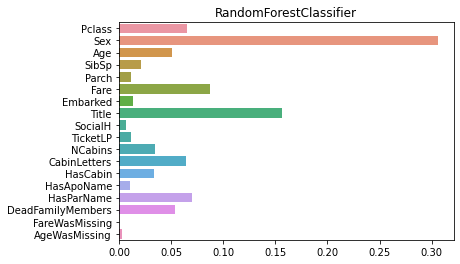

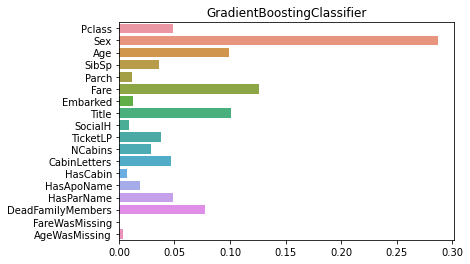

LogisticRegression has no feature importances


In [40]:
# plotting the feature importances:
for cla in classifiers:
    try:
        sns.barplot(y = X_train.columns, x = cla.feature_importances_)
        plt.title(f'{cla.__class__.__name__}')
        plt.show()
    except:
        print(f'{cla.__class__.__name__} has no feature importances')

# Looking at correlations to figure out what might be redundant:

In [41]:
#ttrain.corr()

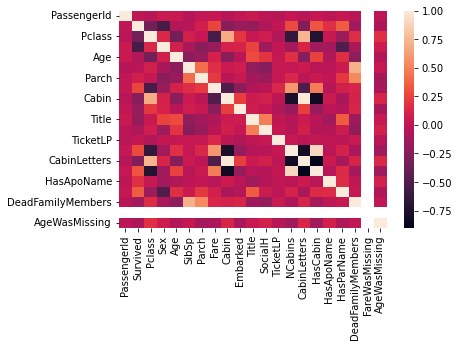

In [42]:
sns.heatmap(data = ttrain.corr())
plt.show()

In [43]:
ttrain.corr()['SibSp']

PassengerId         -0.057527
Survived            -0.035322
Pclass               0.083081
Sex                 -0.114631
Age                 -0.233296
SibSp                1.000000
Parch                0.414838
Fare                 0.159651
Cabin                0.043525
Embarked             0.068043
Title               -0.200046
SocialH             -0.254618
TicketLP             0.021284
NCabins              0.012150
CabinLetters         0.047273
HasCabin            -0.040460
HasApoName          -0.020319
HasParName           0.042196
DeadFamilyMembers    0.712545
FareWasMissing            NaN
AgeWasMissing        0.018958
Name: SibSp, dtype: float64

# Hyperparameter Tuning:

In [44]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [45]:
#hyperparameter tuning random forest:
gscvrf = GridSearchCV(verbose = 1, n_jobs = -1, estimator = rf, param_grid = {'max_depth':[2,4,6],'min_samples_leaf':[.001, .2,.4]})

gscvrf.fit(X_train,y_train)
y_pred[gscvrf] = gscvrf.predict(X_test)
gscvrf.best_params_


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   52.0s finished


{'max_depth': 6, 'min_samples_leaf': 0.001}

In [46]:
xgb.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [47]:
np.arange(5,xgb.n_features_, 2)

array([ 5,  7,  9, 11, 13, 15, 17])

In [48]:
#parameter tuning xgb:
params = {
    'learning_rate':[.01,.1,.2,.3],
    'max_depth':[2,4,6],
    'n_estimators': [100],
    'max_features': np.arange(5, xgb.n_features_, 2)
}
gscvxgb = GridSearchCV(verbose = 1, n_jobs = -1, estimator = xgb, param_grid = params)
gscvxgb.fit(X_train,y_train)
y_pred[gscvxgb] = gscvxgb.predict(X_test)
gscvxgb.best_params_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   32.4s finished


{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 17, 'n_estimators': 100}

In [49]:
#hyperparameter tuning LogisticRegression:
gscvlr = GridSearchCV(verbose = 1, n_jobs = -1, estimator = lr, param_grid = {'C': [.01,.1,1,10,100]})

gscvlr.fit(X_train,y_train)
y_pred[gscvlr] = gscvlr.predict(X_test)
gscvlr.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


{'C': 1}

idk

In [50]:
# Saving the predictions into a csv according to competition model
result = pd.DataFrame({'PassengerId': ttest['PassengerId'],'Survived':y_pred[xgb]})
result.to_csv('submission.csv', index = False)
print('done')

done
